# Self-Driving Car Engineer Nanodegree

## P2: Build a Traffic Sign Recognition Classifier | Deep Learning

### Data Exploration

#### Load and Setup Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from scipy import misc

import time
import pickle
import random
import itertools
import classifier

from scipy.stats import describe
from six.moves import xrange

%pylab
%matplotlib inline
plt.style.use('ggplot')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/mimoralea/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Loading the data

First of all, we load the data. The data set was stored on a couple of pickle files which are files containing Python objects that were converted into byte stream for more compact storage and serialization.

In [142]:
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
test.keys()

dict_keys(['sizes', 'labels', 'coords', 'features'])

In [4]:
train.keys()

dict_keys(['sizes', 'labels', 'coords', 'features'])

In [5]:
train['sizes']

array([[29, 30],
       [30, 30],
       [30, 30],
       ..., 
       [58, 62],
       [63, 69],
       [68, 69]], dtype=uint8)

In [6]:
train['coords']

array([[ 5,  6, 24, 25],
       [ 5,  5, 25, 25],
       [ 5,  5, 25, 25],
       ..., 
       [ 5,  6, 53, 57],
       [ 5,  7, 58, 63],
       [ 7,  6, 62, 63]], dtype=uint8)

We can see how the only keys we are interested on from these objects are features and labels. The `sizes` property describes the width and height the original image was. And the `coords` property describes the coordinates in which the traffic sign was on. However, these data set has been preprocessed for us. Therefore, we can just go ahead and use the `features` and `labels` provided.

#### Data Statistics

We can now breifly look into the other two properties to get a sense for the data set.

In [132]:
n_classes = len(np.unique(y_train))

n_train = X_train.shape[0]
n_test = X_test.shape[0]

image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


We can see almost 40k training samples, and over 10k test samples. This is about 75:25 split ratio for training and testing respectively. This is a fair split and we will continue with it.

Additionally, we can observe that each image is on a square of 32 pixels, and they are color images with 3 channels for Red, Green and Blue.

Finally, we have a total of 43 different types of traffic signs.

#### Visualize sample images

Let's now visualize a couple of samples.

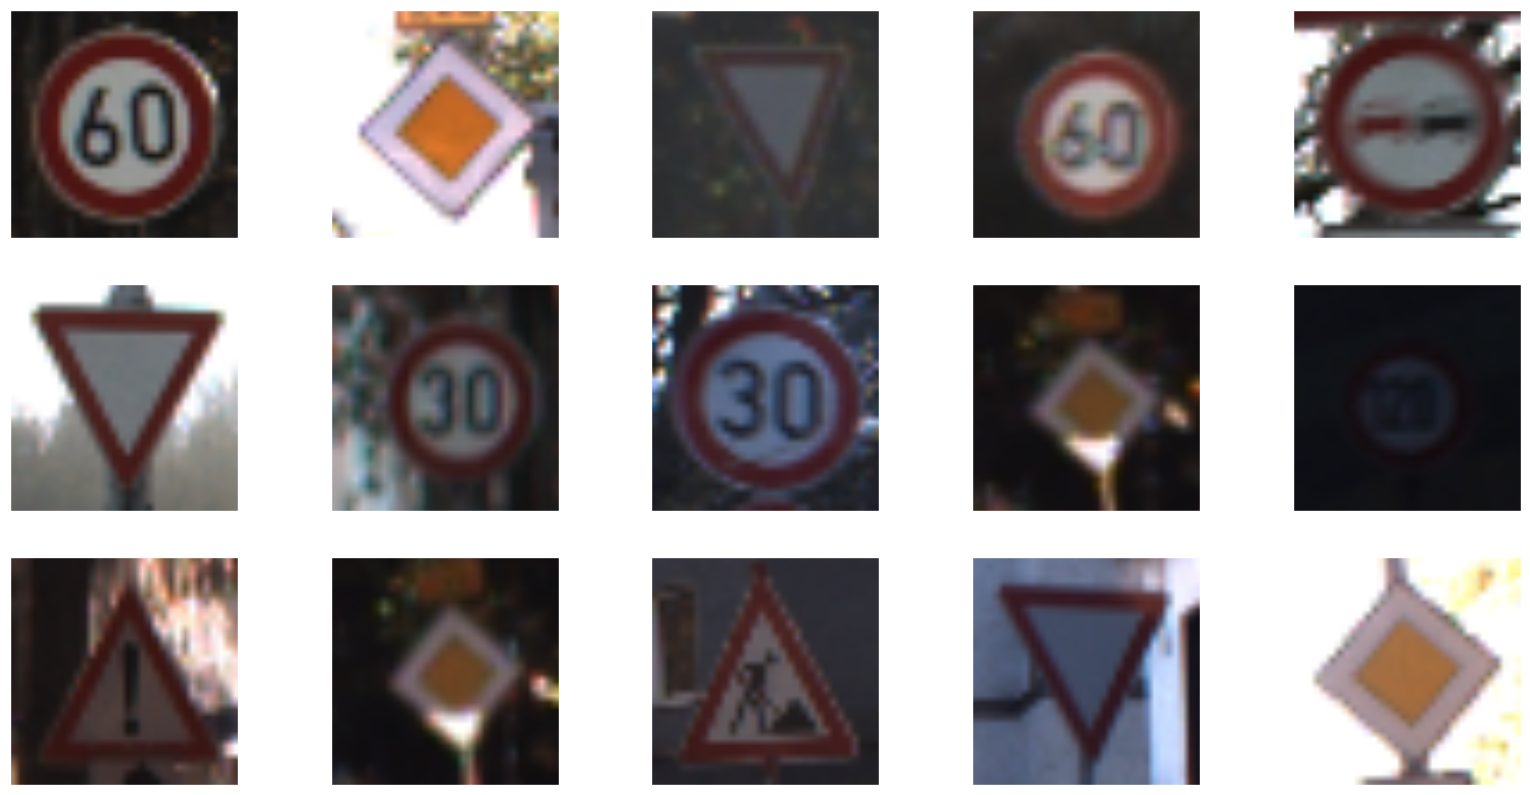

In [8]:
fig = plt.figure(figsize=(20,10))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(X_train[np.random.randint(n_train)])

It looks like a fair data set. Some of the images look crip and clear, while other images look somewhat distorted. Some are blured, some are too dark, some and seen in a difficult angle. However, we can implement a pipeline that simulated some of these distrotions and train the data set to be robust enough to generalize these signs even in the worst conditions.

#### Most and least images per class

Let's look into how many samples each class has:

(array([  210.,  2220.,  2250.,  1410.,  1980.,  1860.,   420.,  1440.,
         1410.,  1470.,  2010.,  1320.,  2100.,  2160.,   780.,   630.,
          420.,  1110.,  1200.,   210.,   360.,   330.,   390.,   510.,
          270.,  1500.,   600.,   240.,   540.,   270.,   450.,   780.,
          240.,   689.,   420.,  1200.,   390.,   210.,  2070.,   300.,
          360.,   240.,   240.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

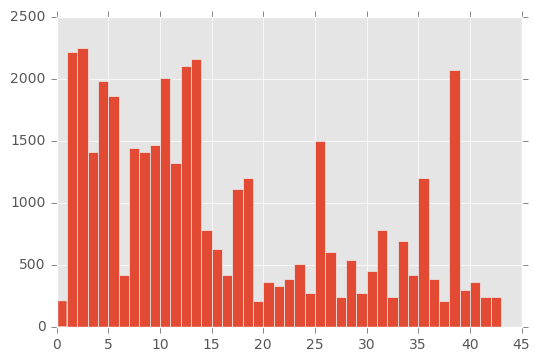

In [103]:
plt.hist(y_train, bins=range(n_classes + 1))

We can see how some of the traffic signs are under-represented. This couple present a problem in which classes that have fewer samples have a lower change of accurately generalizing on the testing data. In fact, let's look into the samples on the test data set.

(array([  60.,  720.,  750.,  450.,  660.,  630.,  150.,  450.,  450.,
         480.,  660.,  420.,  690.,  720.,  270.,  210.,  150.,  360.,
         390.,   60.,   90.,   90.,  120.,  150.,   90.,  480.,  180.,
          60.,  150.,   90.,  150.,  270.,   60.,  210.,  120.,  390.,
         120.,   60.,  690.,   90.,   90.,   60.,   90.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

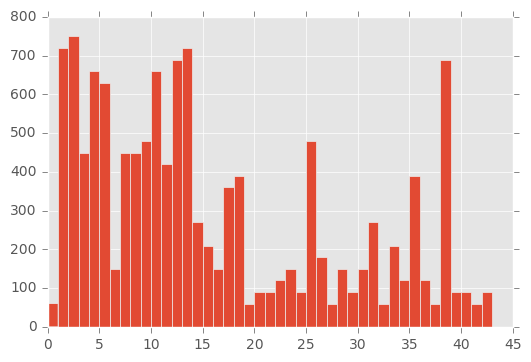

In [104]:
plt.hist(y_test, bins=range(n_classes + 1))

It look like the samples were split into train/test uniformly randomly as we can see a very similar trend on the test and train sets. Let's look a little more into the samples that are over vs under represented.

In [11]:
sign_strings = pd.read_csv('signnames.csv', index_col=0)
least_seen = [0,38,39,40,41,42]
most_seen = [1,2,4,5,12,13]

In [12]:
sign_strings.loc[least_seen,:]

SignName
ClassId                                                   
0                                     Speed limit (20km/h)
38                                              Keep right
39                                               Keep left
40                                    Roundabout mandatory
41                                       End of no passing
42       End of no passing by vechiles over 3.5 metric ...

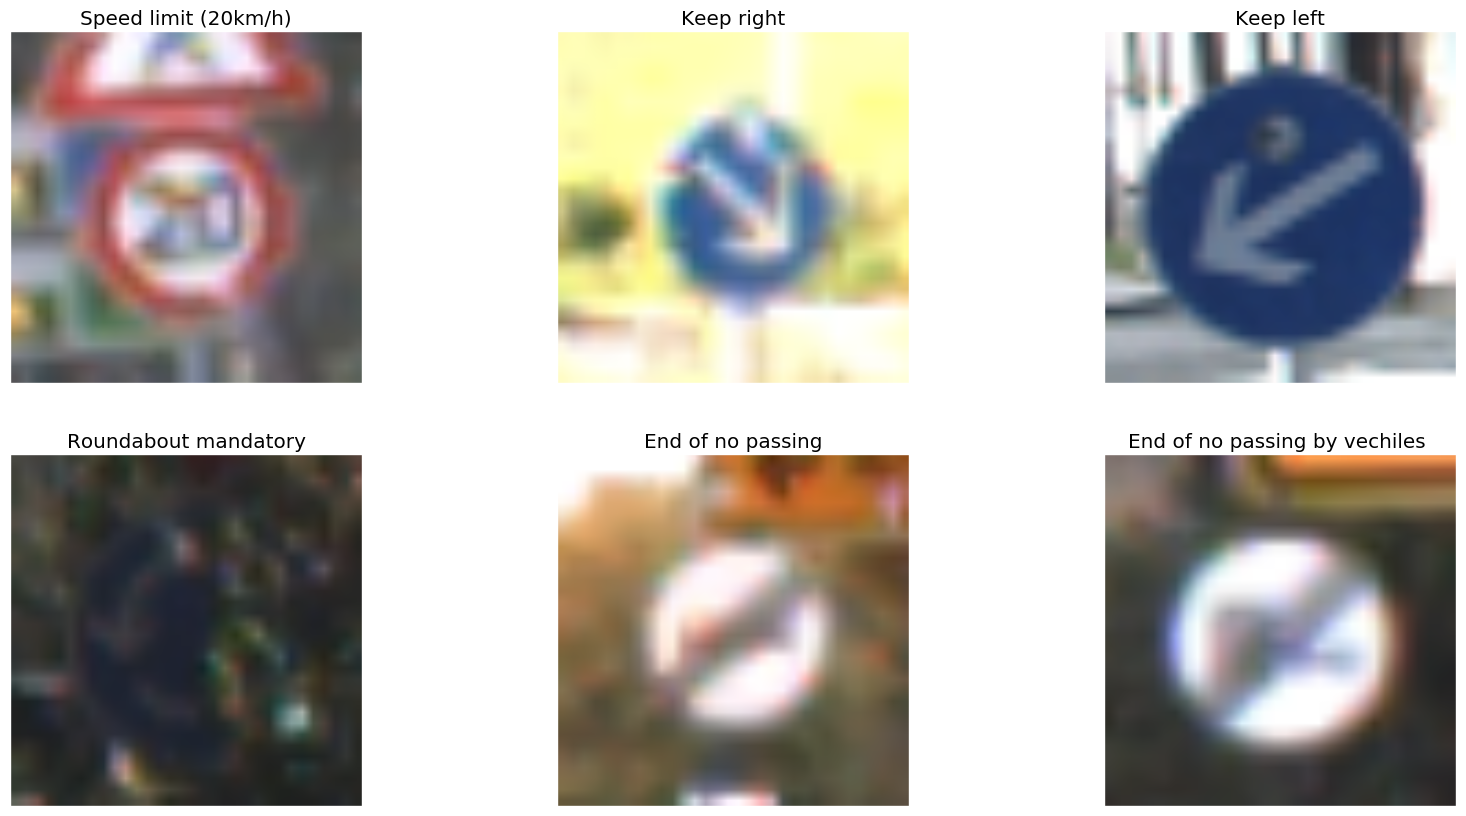

In [13]:
fig = plt.figure(figsize=(20,10))

for i, c in enumerate(least_seen):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[c,'SignName'][:30])
    idx = np.squeeze(np.argwhere(y_train == c))[0]
    ax.imshow(X_train[idx])

In [14]:
sign_strings.loc[most_seen,:]

SignName
ClassId                      
1        Speed limit (30km/h)
2        Speed limit (50km/h)
4        Speed limit (70km/h)
5        Speed limit (80km/h)
12              Priority road
13                      Yield

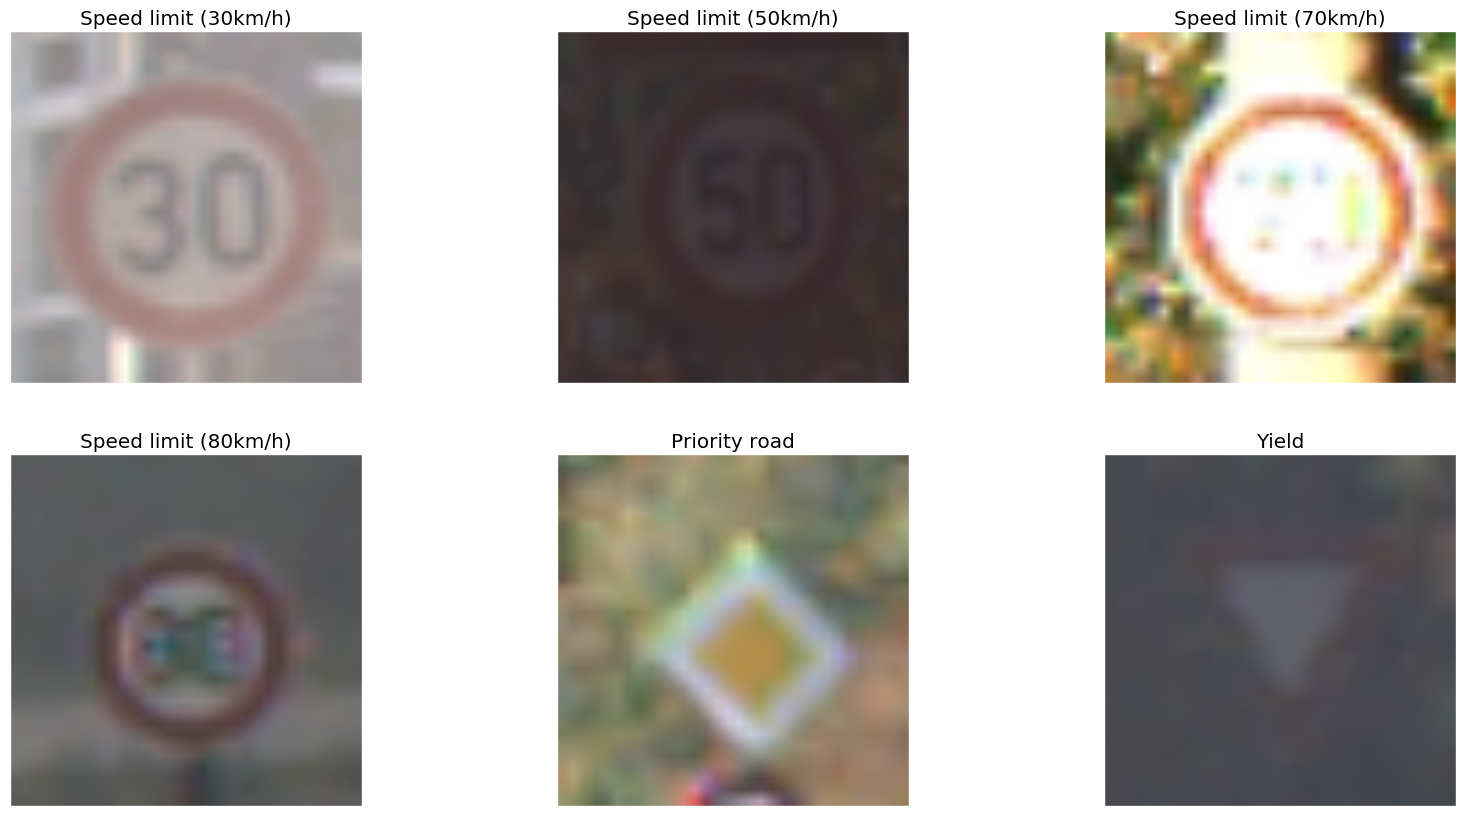

In [15]:
fig = plt.figure(figsize=(20,10))

for i, c in enumerate(most_seen):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[c,'SignName'][:30])
    idx = np.squeeze(np.argwhere(y_train == c))[0]
    ax.imshow(X_train[idx])

We can observe the traffic signs that are under represented as the 20km limit, keep right and left, roundabout and so on. While the over represent being the common speed limits, priority road and yield.

Later, we will artificially generate augmented images from the original data set. Also, we will be selecting a validation set with equal amount of samples per class. 

#### Mean and Std images

One interesting visualization we can look into is the average, and standard deviation image. The mean images would tell us how would an image that represents all images look like. The standard deviation image would tell us where in the image is change likely to happen. Finally we will relate these two in order to visualize where and how much variance is in the mean representation of the traffic sign.

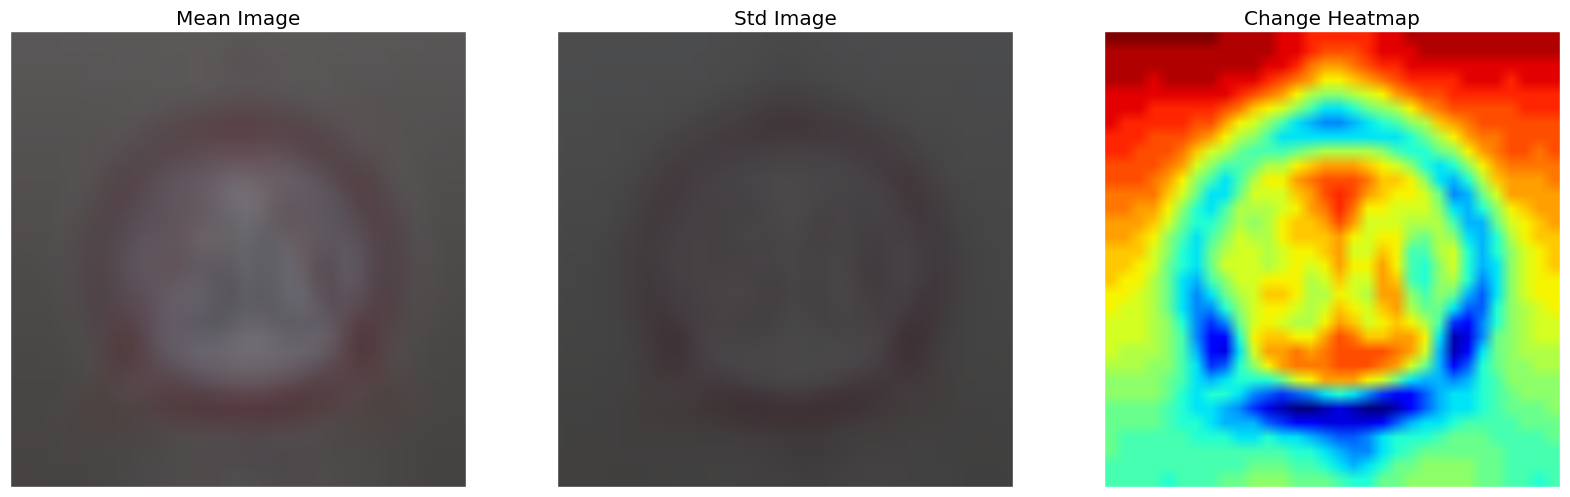

In [16]:
mean_img = np.mean(X_train, axis=0)
std_img = np.std(X_train, axis=0)
heat_img = np.mean(std_img, axis=2)

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.grid(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.set_title('Mean Image')
ax1.imshow(mean_img.astype(np.uint8))

ax2 = fig.add_subplot(1, 3, 2)
ax2.grid(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.set_title('Std Image')
ax2.imshow(std_img.astype(np.uint8))

ax3 = fig.add_subplot(1, 3, 3)
ax3.grid(False)
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.imshow(std_img.astype(np.uint8))
ax3.set_title('Change Heatmap')
ax3.imshow(heat_img.astype(np.uint8))

It is very interesting to see these images. The left tells us how does the blended image of all images look like. We can assume that the number of speed limit images are far greater than others since the blended image looks very much like one of those.

The image on the right tells us, on average, how much each color channel will change as a heat map. The more red the more likely our mean image is different from the each image, and the more blue, the more likely our mean image accurately represents any given image.

The point of these explorations is that machine learning is about building models that understand invariances. We need our model to be able to generalize unseen data. By modeling the mean and the standard deviation of the dataset, we are able to understand what our model should be able to generalize properly.

Given these visualizations we could assume that whitening the images or normalizing them could actually represent beneficial. This process consists of removing the mean and the standard deviation from the images keeping a dataset that only contains the variations of the data. This would be a simple operation such as substracting the mean and dividing by the standard deviation.

In [17]:
flattened = X_train.ravel()
flattened[:50]

array([ 75,  78,  80,  74,  76,  78,  83,  84,  83, 101,  92,  85, 130,
       107, 102, 153, 113, 114, 173, 114, 117, 188, 124, 124, 190, 151,
       150, 243, 228, 230, 255, 250, 255, 243, 239, 255, 232, 235, 255,
       170, 180, 212, 127, 146, 182, 124, 153, 175, 156, 181], dtype=uint8)

We can further explore the images by visualizing the distribution or range of frequency of possible values are. This would tell us whether the data is predictable or not by pointing things that would happen more than anything else. If there is, a Neural Network would be able to take advantage of it.

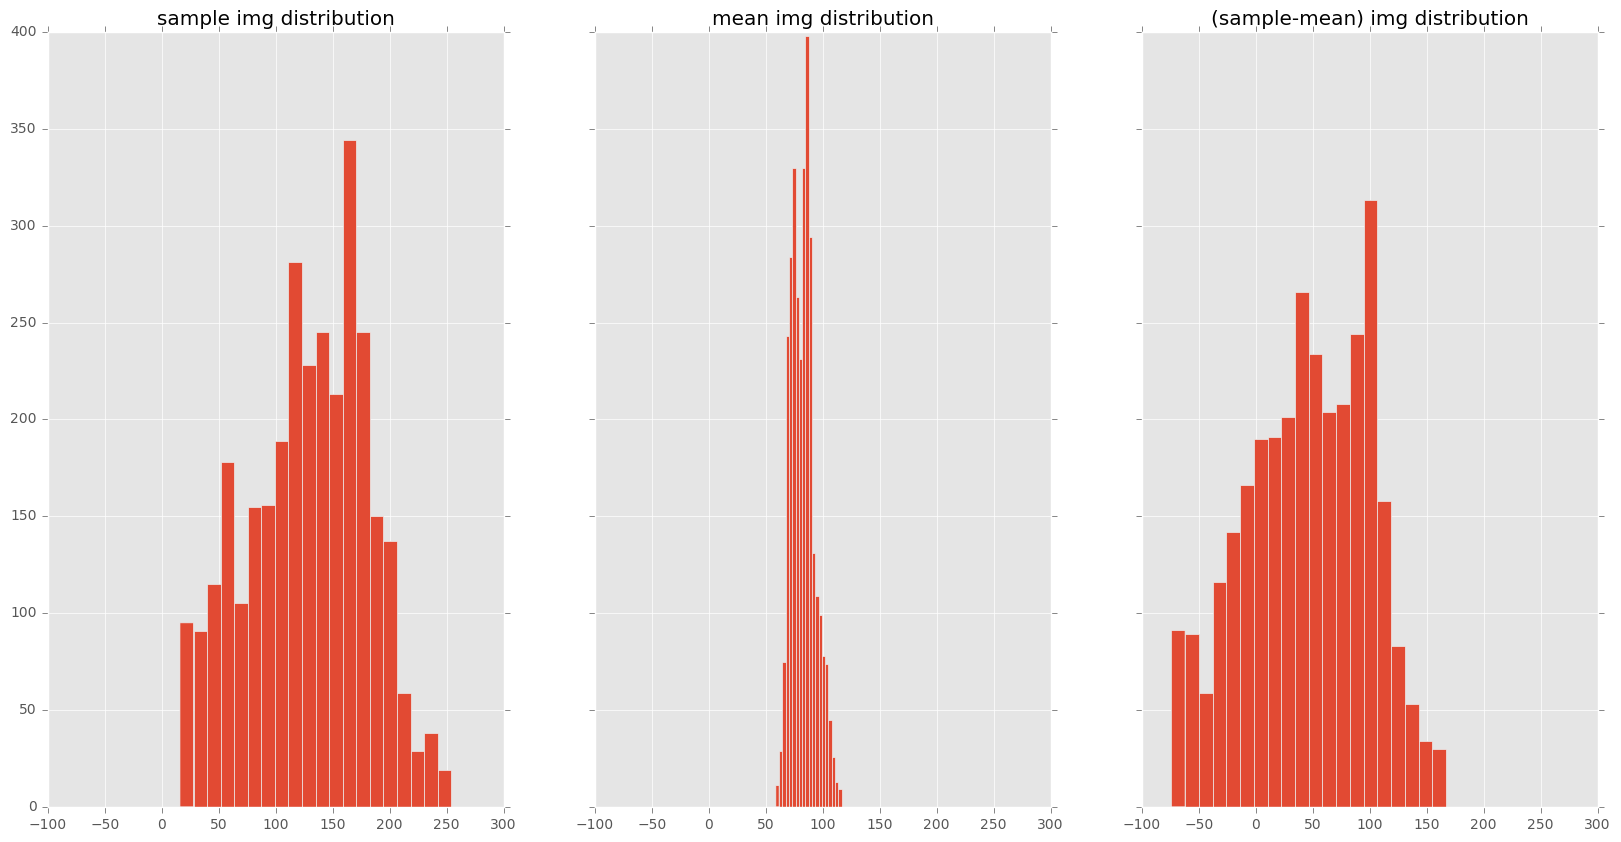

In [18]:
bins = 20
img = X_train[100]

fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True, sharex=True)
axs[0].hist(img.ravel(), bins)
axs[0].set_title('sample img distribution')
axs[1].hist(mean_img.ravel(), bins)
axs[1].set_title('mean img distribution')
axs[2].hist((img-mean_img).ravel(), bins)
axs[2].set_title('(sample-mean) img distribution')

From the graph we can see the number of pixels intensity distribution, the mean image distribution around 80 and then the normalized image showing the number of pixels that were above and below the mean for this particular image.

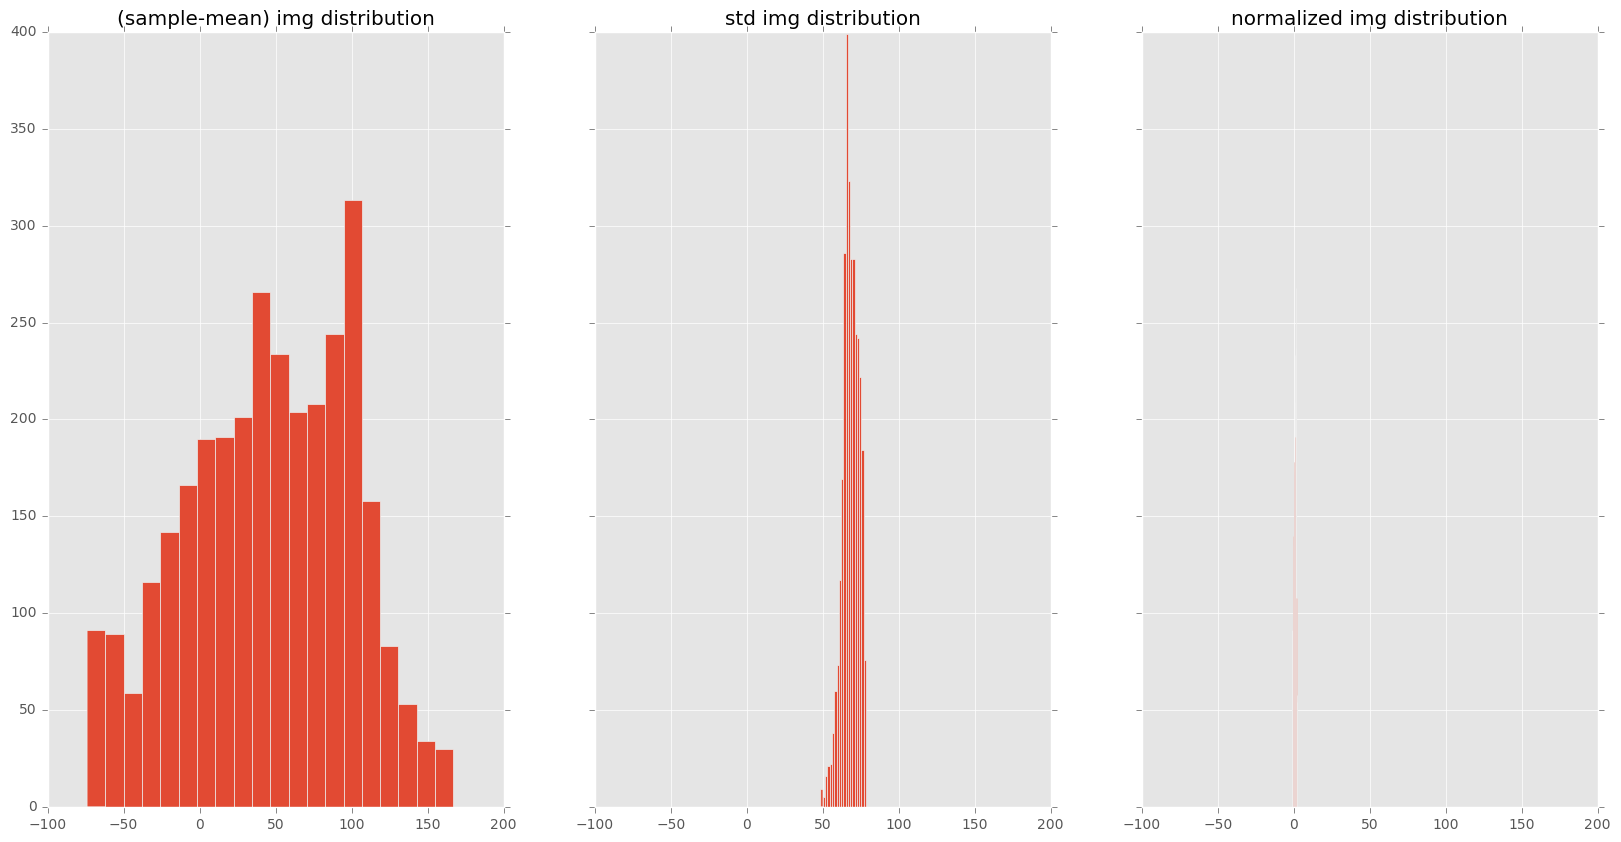

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True, sharex=True)
axs[0].hist((img-mean_img).ravel(), bins)
axs[0].set_title('(sample-mean) img distribution')
axs[1].hist(std_img.ravel(), bins)
axs[1].set_title('std img distribution')
axs[2].hist(((img-mean_img)/std_img).ravel(), bins)
axs[2].set_title('normalized img distribution')

We can hardly see the normalized values, but let's zoom in to be able to better identify the distribution.

(array([  91.,   93.,   74.,  135.,  140.,  144.,  173.,  172.,  178.,
         233.,  209.,  190.,  191.,  176.,  237.,  268.,  148.,  108.,
          54.,   58.]),
 array([-0.97876036, -0.817667  , -0.65657365, -0.49548029, -0.33438693,
        -0.17329357, -0.01220021,  0.14889315,  0.3099865 ,  0.47107986,
         0.63217322,  0.79326658,  0.95435994,  1.1154533 ,  1.27654665,
         1.43764001,  1.59873337,  1.75982673,  1.92092009,  2.08201345,
         2.2431068 ]),
 <a list of 20 Patch objects>)

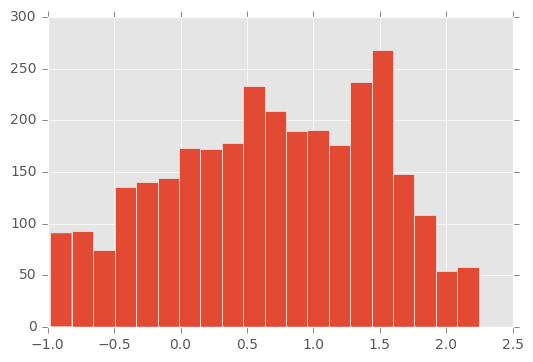

In [20]:
plt.hist(((img-mean_img)/std_img).ravel(), bins)

By normalizing the dataset, all the values would tend to be around 0 and on a smaller range, in this case from -2 to 2. This could turn into better calculations accuracies and performance speed gains. We will later pre-process the data set to include image normalization.

### Model Design

#### Overall Design

![title](imgs/overall-architecture.png)

#### Images Preprocessing Pipeline 

First, we removed the 10% of the training set for validation proposes. This enabled us to cross validate the model during training this way ensuring that we did not overfit the model to the training data.

Also, we augmented the data online during training, also called realtime augmentation. This allowed us to combine the image rescaling and augmentation into a single process, allowing us to use the power of the GPU and CPU at the same time. We augmented the images on the CPU and processed the training on the GPU.

In [21]:
def augment_image(img):
    img = tf.random_crop(img, [24, 24, 3])
    img = tf.image.random_hue(img, 0.25)
    img = tf.image.random_saturation(img, lower=0, upper=10)
    img = tf.image.random_brightness(img, max_delta=0.8)
    img = tf.image.random_contrast(img, lower=0, upper=10)
    img = tf.image.per_image_whitening(img)
    return img
    
def augment_images(images):
    _, img_height, img_width, _ = images.get_shape().as_list()
    images = tf.map_fn(lambda img: augment_image(img), images)
    images = tf.image.rgb_to_grayscale(images)
    images = tf.image.resize_images(images, (img_height, img_width),
                                    method=0,
                                    align_corners=False)
    return images

We can see here the functions we used to augment the data set. Random crops, color saturation, brightness and contrast, then image whitening and finally transform the color image the grayscale, resizing the batch of all images to the 32x32 the CNN was designed for.

Let's visulize these operations on some randomly selected images.

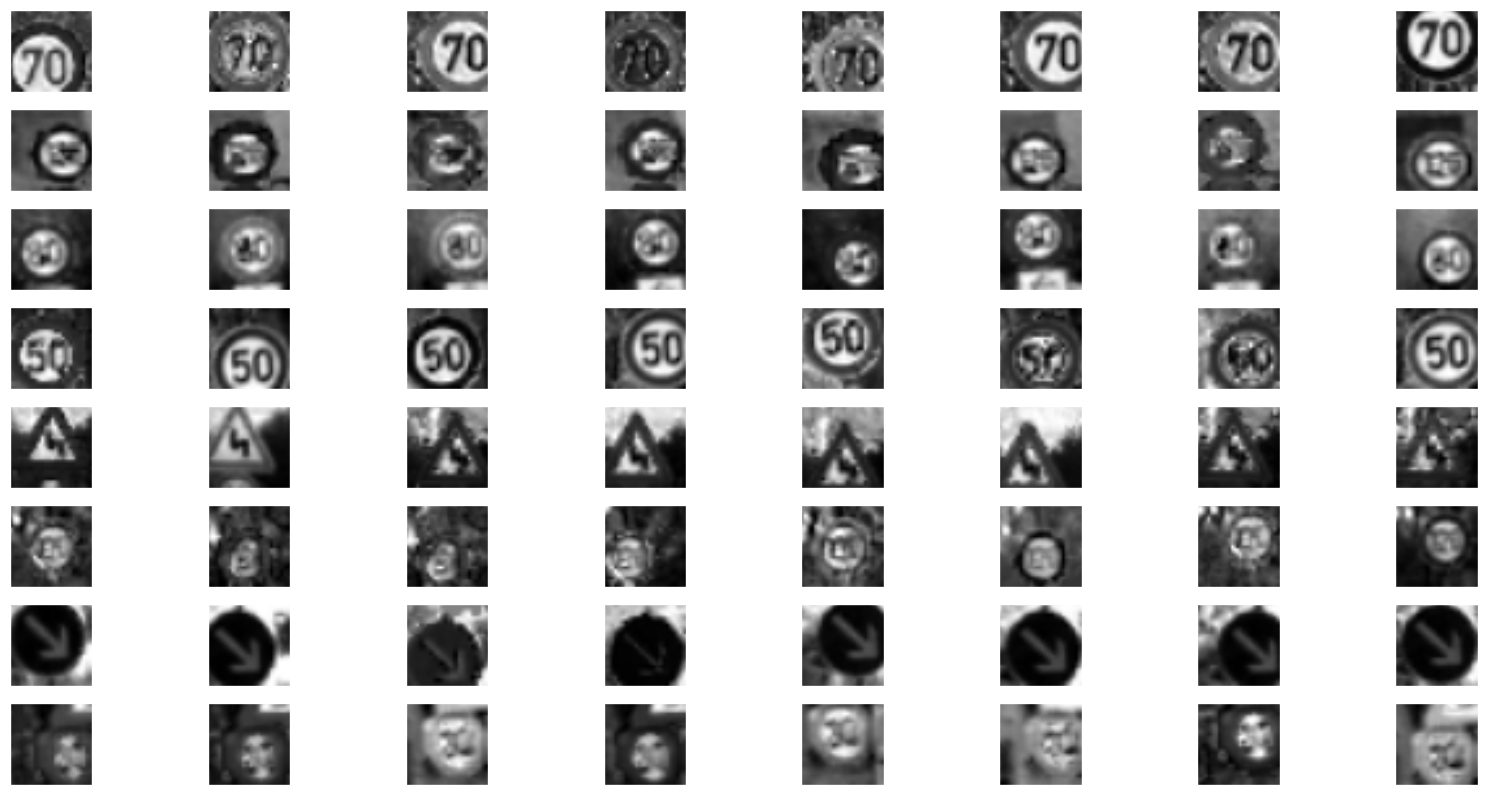

In [22]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        img = X_train[np.random.randint(n_train)]
        imgs = []
        orgs = []
        for i in range(64):
            if i % 8 == 0 :
                img = X_train[np.random.randint(n_train)]
                orgs.append(img)
            imgs.append(img)
        img_placeholder = tf.placeholder(tf.float32, shape=[64, 32, 32, 3])
        images = augment_images(img_placeholder)
        images = sess.run(images, feed_dict={img_placeholder:imgs})
        
        fig = plt.figure(figsize=(20,10))
        for i in range(64):
            ax = fig.add_subplot(8, 8, i + 1)
            ax.grid(False)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.imshow(np.squeeze(images[i]), cmap='gray')

We decided not to use other augmentation methods such as flips because the likelihood of encountering a fliped sign on the real world is unlikely. And more importantly, flipping the sign could potentially change any given sign. For example, a "Keep Right" sign flipped would show "Keep Left" making this an issue for training. 

#### Convolutions And Poolings

![title](imgs/convolutions.png)

#### Neural Network Classifier Architecture

![title](imgs/fully-connected-neural-network.png)

### Model Implementation

The model implementation is fully setup on the file `classifier.py`, however, we will show a condensed version of the how the model is implemented on this section.

#### Code Samples: Helper Functions

In [23]:
def _variable_on_cpu(name, shape, initializer):
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

def _variable_with_weight_decay(name, shape, stddev, wd):
    var = _variable_on_cpu(
            name,
            shape,
            tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
    return var

#### Code Samples: Convolutional and Pooling Layers

In [24]:
def convolutions(images):

    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 1, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        bias = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(bias, name=scope.name)

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='SAME', name='pool1')

    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 64, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
        bias = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(bias, name=scope.name)

    # norm2
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, 
                      beta=0.75, name='norm2')

    # pool2
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], 
                           padding='SAME', name='pool2')
    return pool2

#### Code Samples: Deep Convolutional Network

In [25]:
def fully_connected_nn(pool2, keep_prob=0.4, n_classes = 43):
    # local3
    with tf.variable_scope('local3') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        dim = np.prod(pool2.get_shape().as_list()[1:])
        reshape = tf.reshape(pool2, [-1, dim])
        weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # local4
    with tf.variable_scope('local4') as scope:
        weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)

    # dropout
    local4_drop = tf.nn.dropout(local4, keep_prob)

    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [192, n_classes],
                                              stddev=1/192.0, wd=0.0)
        biases = _variable_on_cpu('biases', [n_classes],
                                  tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(local4_drop, weights), biases, name=scope.name)

    # normalized `sum(logits) == 1`
    softmax_normalized = tf.nn.softmax(softmax_linear)
    return softmax_normalized

#### Code Samples: Loss function

In [26]:
def loss_func(logits, labels):
    """L2Loss"""
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)

    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

#### Code Samples: Training Step

In [27]:
def train_step(total_loss, global_step):
    # Variables that affect learning rate.
    num_batches_per_epoch = 50000 / 128
    decay_steps = int(num_batches_per_epoch * 350.0)

    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay(0.05,
                                    global_step,
                                    decay_steps,
                                    0.1,
                                    staircase=True)
    # Calculate gradients.
    opt = tf.train.GradientDescentOptimizer(lr)
    grads = opt.compute_gradients(total_loss)

    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(0.9999, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())

    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')

    return train_op

#### Sample Code: Core Training Process 

In [28]:
def train_main():
    with tf.Graph().as_default():

        # Set variables
        global_step = tf.Variable(0, trainable=False)
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        # Augment images batch
        process_op = augment_images(images_p)

        # Calculate the logits and loss
        pool2 = convolutions(process_op)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)
        loss = loss_func(logits, labels_p)

        # Create a training operation that updates the
        # network parameters
        train_op = train_step(loss, global_step)

        # Build an initialization operation to run below.
        init = tf.initialize_all_variables()

        # Start running operations on the Graph.
        sess = tf.Session(config=tf.ConfigProto(
            log_device_placement=False))
        sess.run(init)

        # Start the queue runners.
        tf.train.start_queue_runners(sess=sess)

        total_training_time = 0
        for step in xrange(1001):
            start_time = time.time()
            idx = np.random.randint(len(X_train), size=128)
            sess.run(train_op, feed_dict={images_p:X_train[idx],
                                          labels_p:y_train[idx],
                                          keep_prob_p:0.4})
            loss_value = sess.run(loss, feed_dict={images_p:X_train[idx],
                                                   labels_p:y_train[idx],
                                                   keep_prob_p:1.0})
            duration = time.time() - start_time
            total_training_time += duration
            assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

            if step % 100 == 0:
                examples_per_sec = 128 / duration
                sec_per_batch = float(duration)

                format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (datetime.datetime.now(), step, loss_value,
                                   examples_per_sec, sec_per_batch))

#### Sample Code: Sample Training Run 

In [25]:
train_main()

2016-11-23 18:37:40.671453: step 0, loss = 7.85 (100.8 examples/sec; 1.270 sec/batch)
2016-11-23 18:39:39.295877: step 100, loss = 7.69 (108.9 examples/sec; 1.176 sec/batch)
2016-11-23 18:41:40.971408: step 200, loss = 7.53 (105.3 examples/sec; 1.215 sec/batch)
2016-11-23 18:43:44.033189: step 300, loss = 7.38 (107.4 examples/sec; 1.192 sec/batch)
2016-11-23 18:45:47.427546: step 400, loss = 7.23 (93.6 examples/sec; 1.368 sec/batch)
2016-11-23 18:47:52.625701: step 500, loss = 7.07 (108.7 examples/sec; 1.178 sec/batch)
2016-11-23 18:49:53.581185: step 600, loss = 6.95 (109.2 examples/sec; 1.172 sec/batch)
2016-11-23 18:51:54.445363: step 700, loss = 6.83 (103.7 examples/sec; 1.234 sec/batch)
2016-11-23 18:53:55.568932: step 800, loss = 6.70 (106.1 examples/sec; 1.206 sec/batch)
2016-11-23 18:55:56.473748: step 900, loss = 6.57 (102.9 examples/sec; 1.244 sec/batch)
2016-11-23 18:57:59.600602: step 1000, loss = 6.40 (111.4 examples/sec; 1.149 sec/batch)


#### Comments About Training

Training time, etc

#### Visualizing Conv1 Filters

After fully training the model, we are able to collect the weights on the convolutions and plot them here:

In [29]:
fig = plt.figure(figsize=(20,20))
arr = np.load('checkpoint_dir/conv1_weights_999999.npz')

# Get each 5x5 filter from the 5x5x1x32 array
for filter_ in range(arr.shape[3]):

    # Get the 5x5x1 filter:
    extracted_filter = arr[:, :, :, filter_]
    
    # Get rid of the last dimension (hence get 5x5):
    extracted_filter = np.squeeze(extracted_filter)

    # display the filter (might be very small - you can resize the window)
    ax = fig.add_subplot(8, 8, filter_ + 1)
    #ax.title('filter ' + str(filter_))
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(extracted_filter, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_dir/conv1_weights_999999.npz'

#### Visualizing Conv2 Filters

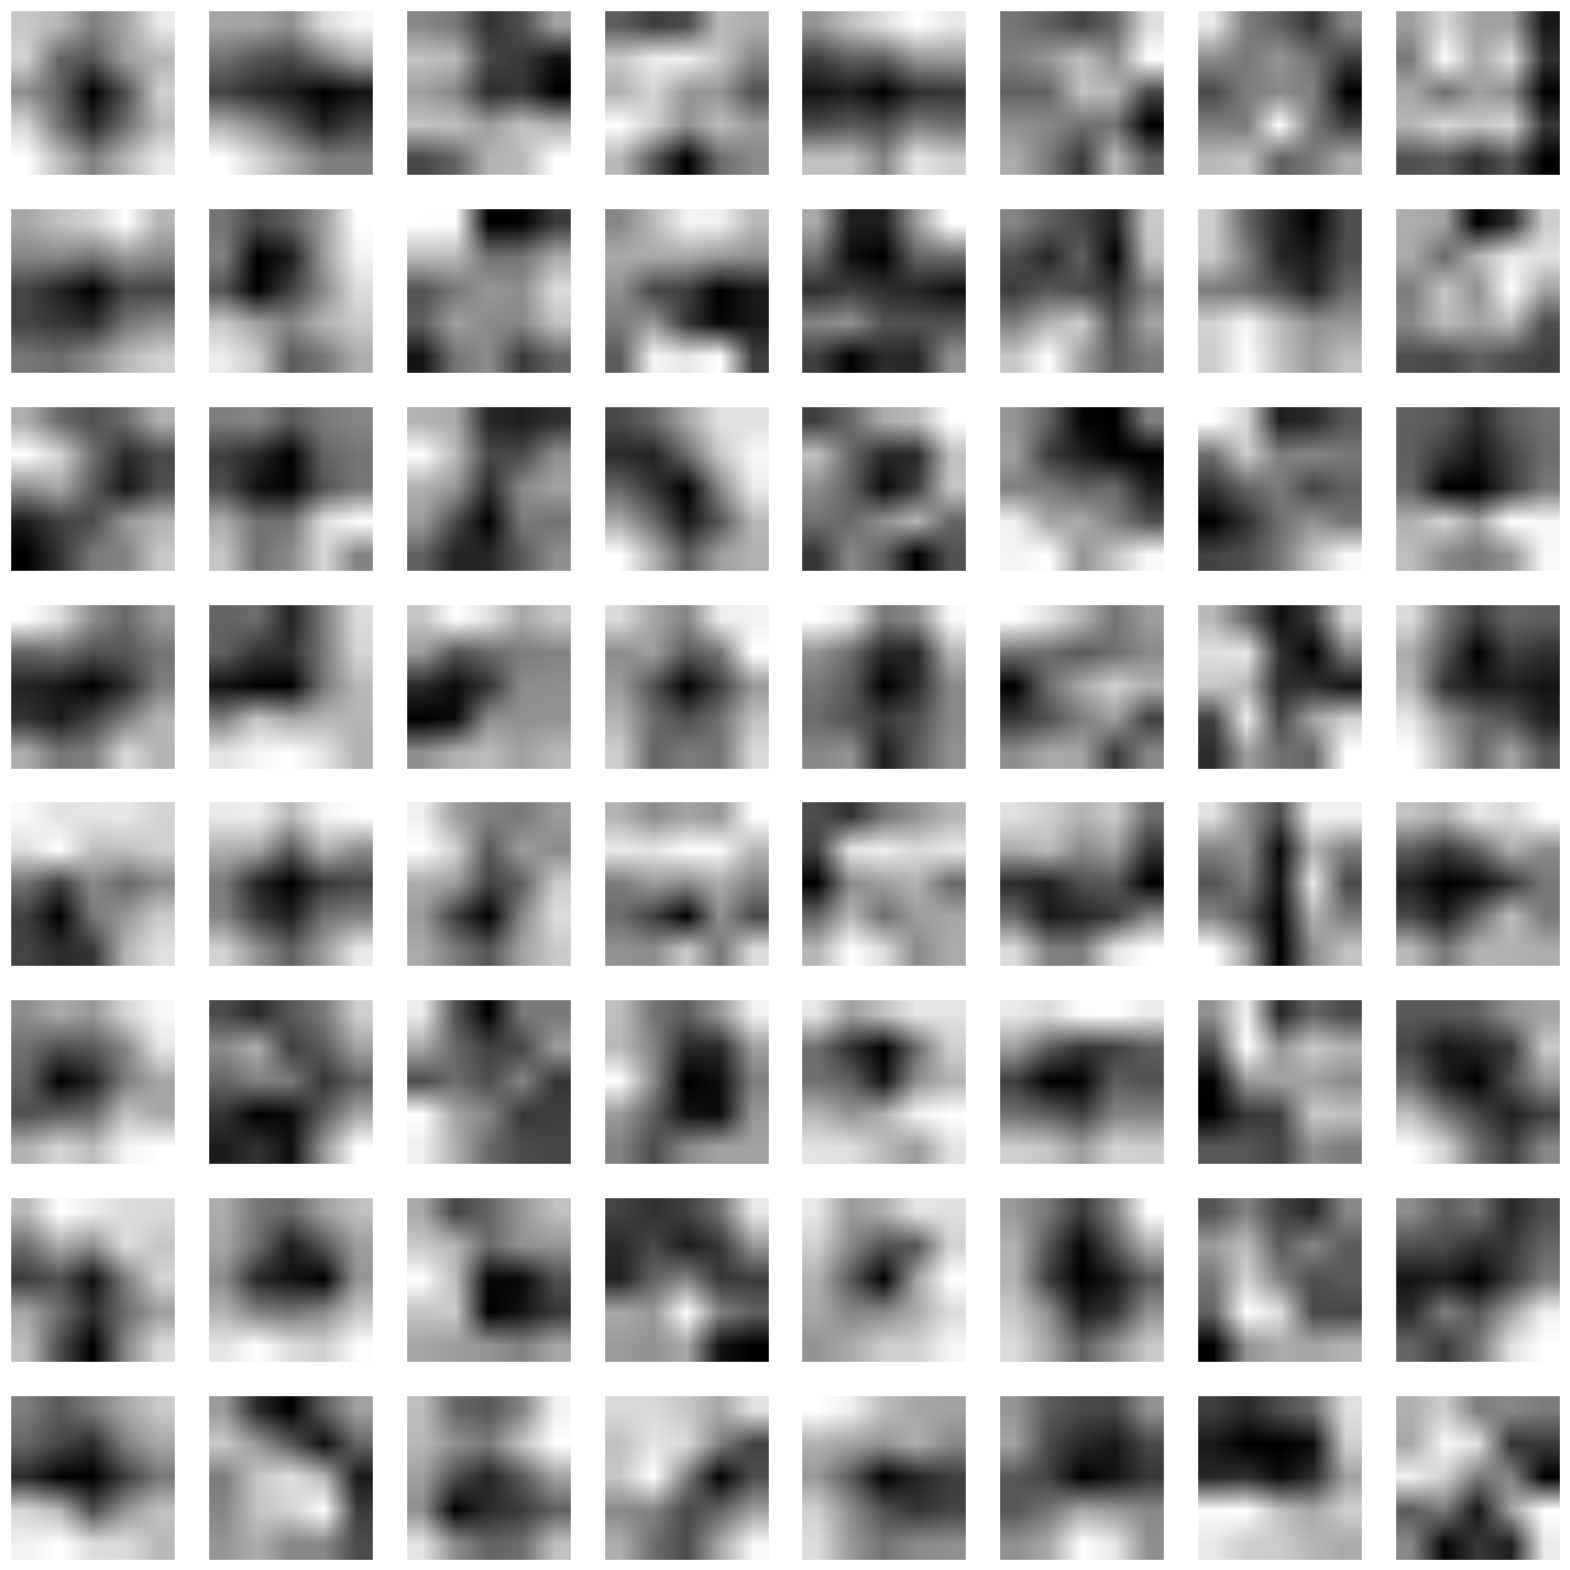

In [267]:
fig = plt.figure(figsize=(20,20))
arr = np.load('checkpoint_dir/conv2_weights_999999.npz')

# Get each 5x5 filter from the 5x5x1x32 array
for filter_ in range(arr.shape[3]):

    # Get the 5x5x1 filter:
    extracted_filter = arr[:, :, :, filter_]
    
    # Get rid of the last dimension (hence get 5x5):
    extracted_filter = np.mean(extracted_filter, axis=2)
    
    # display the filter (might be very small - you can resize the window)
    ax = fig.add_subplot(8, 8, filter_ + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(extracted_filter, cmap='gray')

We can see how the first convolution have more basic shapes like vertical, horizontal and diagonal lines while the second convolution have a combination of these first convolution. These are the parts that compose the features for the classifier. 

### Model Evaluation

#### Training, Validation and Testing data

A traditional training and testing split is usually sufficient for most Machine Learning tasks, however, it is useful to add a third set, called validation set that will serve to ensure that we don't overfit our model to the training data.

The idea is that we train our samples on the training set and often, during training, we check the accuracy of our model against the training set and also against the validation set. If the accuracy improves on the training set but get worse on the validation set for a number of steps we are overfitting our model and should stop training. The test set stays as a separate set of unseen data for model comparison.

For this, we extracted 20 samples of each of the classes from the train data set and use this as validation. It is important to note that even though the class distribution is imbalanced, our approach of selecting a balanced set ensure our accuracies are correct. 

We considered extracting those samples from the testing data set. However, given that some of the classes have very few samples, it could have been a problem. Also, separating more samples from the training set would have also been a problem. Therefore, we selected only 20 samples per class for a total of 860 samples.

In the histogram below, we can see how some classes have very few number of samples.

(array([  190.,  2200.,  2230.,  1390.,  1960.,  1840.,   400.,  1420.,
         1390.,  1450.,  1990.,  1300.,  2080.,  2140.,   760.,   610.,
          400.,  1090.,  1180.,   190.,   340.,   310.,   370.,   490.,
          250.,  1480.,   580.,   220.,   520.,   250.,   430.,   760.,
          220.,   669.,   400.,  1180.,   370.,   190.,  2050.,   280.,
          340.,   220.,   220.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

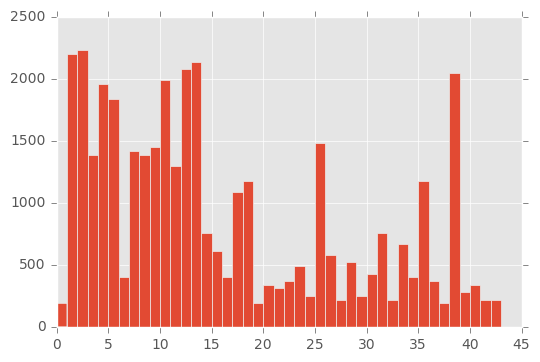

In [207]:
plt.hist(y_train, bins=range(n_classes + 1))

The following snippet shows how we proceeded to extract 20 samples per class:

(array([ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

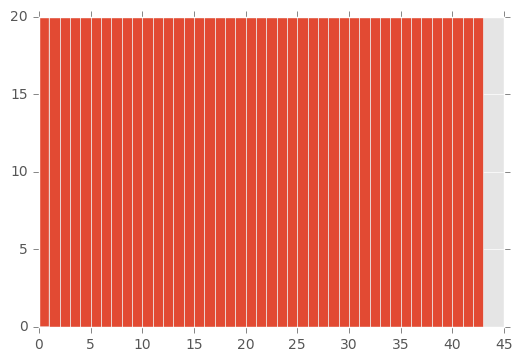

In [209]:
idxs = np.array([], dtype=np.int32)
for i in range(n_classes):
    idxs = np.append(idxs, np.random.choice(np.where(y_train == i)[0], size=20, replace=False))
plt.hist(y_train[idxs], bins=range(n_classes + 1))

Then, we extract the samples from the training set and put them into 2 new variables for validation.

(array([ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

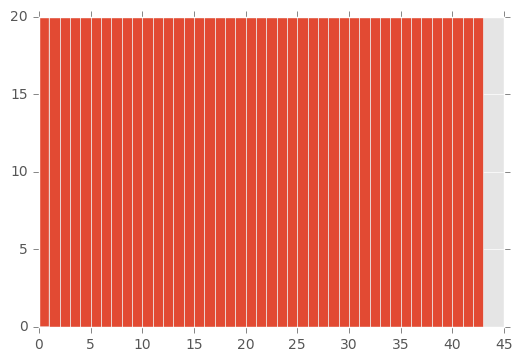

In [211]:
X_validation, y_validation = X_train[idxs], y_train[idxs]
plt.hist(y_validation, bins=range(n_classes + 1))

Finally, we remove these samples from the original training set.

In [199]:
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

y_train = np.delete(y_train, idxs, 0)
X_train = np.delete(X_train, idxs, 0)

We can see from the histogram below that there are still enough samples left for training which is very important.

(array([  190.,  2200.,  2230.,  1390.,  1960.,  1840.,   400.,  1420.,
         1390.,  1450.,  1990.,  1300.,  2080.,  2140.,   760.,   610.,
          400.,  1090.,  1180.,   190.,   340.,   310.,   370.,   490.,
          250.,  1480.,   580.,   220.,   520.,   250.,   430.,   760.,
          220.,   669.,   400.,  1180.,   370.,   190.,  2050.,   280.,
          340.,   220.,   220.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

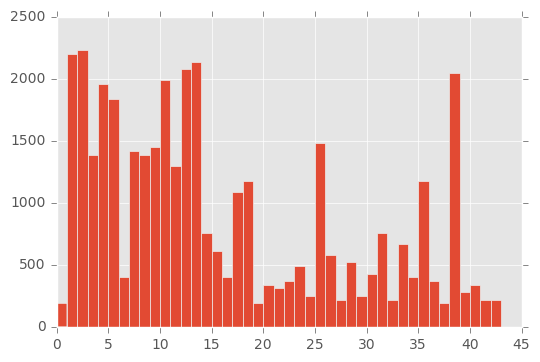

In [213]:
plt.hist(y_train, bins=range(n_classes + 1))

Similarly, our approach for training follows the same principles. One of the biggest challenges we encountered is to make sure all classes were being trained on. Since we picked an Stochastic Gradient Descent approach, the fact that the samples were drawn at random presented a problem. At first, the chance of a class which contains about 200 samples were less than 1%. And as we can see in the histogram, there are many such cases. For this reason, we designed balanced approach which gives equal probability for each class to be drawn on each training step.

As we can see in the code snippet below, we first randomly select without replacement 100 samples of each class. And right after, we randomly select without replacement 128 samples for our training batch. This ensures we get equal probability of each class to be represented on each training iteration.

In [214]:
batch_idxs = np.array([], dtype=int32)
for i in range(n_classes):
    batch_idxs = np.append(batch_idxs, np.random.choice(np.where(y_train == i)[0], size=100, replace=False))
idx = np.random.choice(batch_idxs, size=128, replace=False)
idx

array([21608, 30925, 26073,  6853, 26674, 26305,  1772, 27027, 26564,
       37690, 15514,  9862, 29745, 22483,  9941,  7932, 19554, 26114,
       16555, 33061, 30117, 24138, 20256, 22168, 18318, 26488, 22508,
        2064, 38266,  8499, 33115, 22166,  5118, 31091, 32229, 27448,
       26110, 35235,  6265,  8599, 32348, 23934, 28173, 27312, 11596,
       27590, 22162, 32806, 33082,  1881, 30088, 27935,  7603, 33209,
        3523, 38225, 13623, 16532, 30924, 28109, 32243, 32439, 10836,
       23463, 32815, 13171, 26434, 20624,  9775, 23704, 22057, 26153,
        5498, 23351,  4947, 27581, 26693, 26243, 24181, 15929, 22972,
       26275, 33107, 12614,  7965,  1810, 12155, 32339,  5201, 23481,
       14806,  3011, 28689, 35852, 30985, 26074, 11253, 25028, 27489,
       19768, 30552, 16579, 10116, 31076, 30094,  6504, 27889, 23445,
       34421, 13793, 26265, 30246, 26414, 37212,  1771, 23265, 31190,
        5961, 17061, 35711, 15361, 27375, 34740, 23599,    78, 31070,
       14333, 37594]

(array([ 1.,  5.,  2.,  5.,  6.,  3.,  3.,  3.,  2.,  4.,  4.,  4.,  3.,
         3.,  6.,  2.,  6.,  3.,  1.,  5.,  7.,  3.,  1.,  6.,  2.,  3.,
         1.,  4.,  1.,  3.,  4.,  0.,  4.,  5.,  3.,  1.,  1.,  1.,  3.,
         0.,  2.,  0.,  2.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

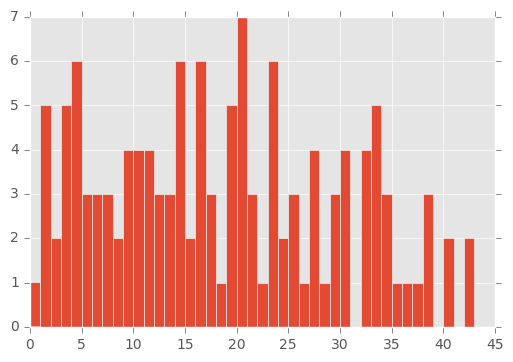

In [216]:
plt.hist(y_train[idx], bins=range(n_classes + 1))

The following figure shows how diverse a subset of the 128 samples looks like. This is a very important step for our solution.

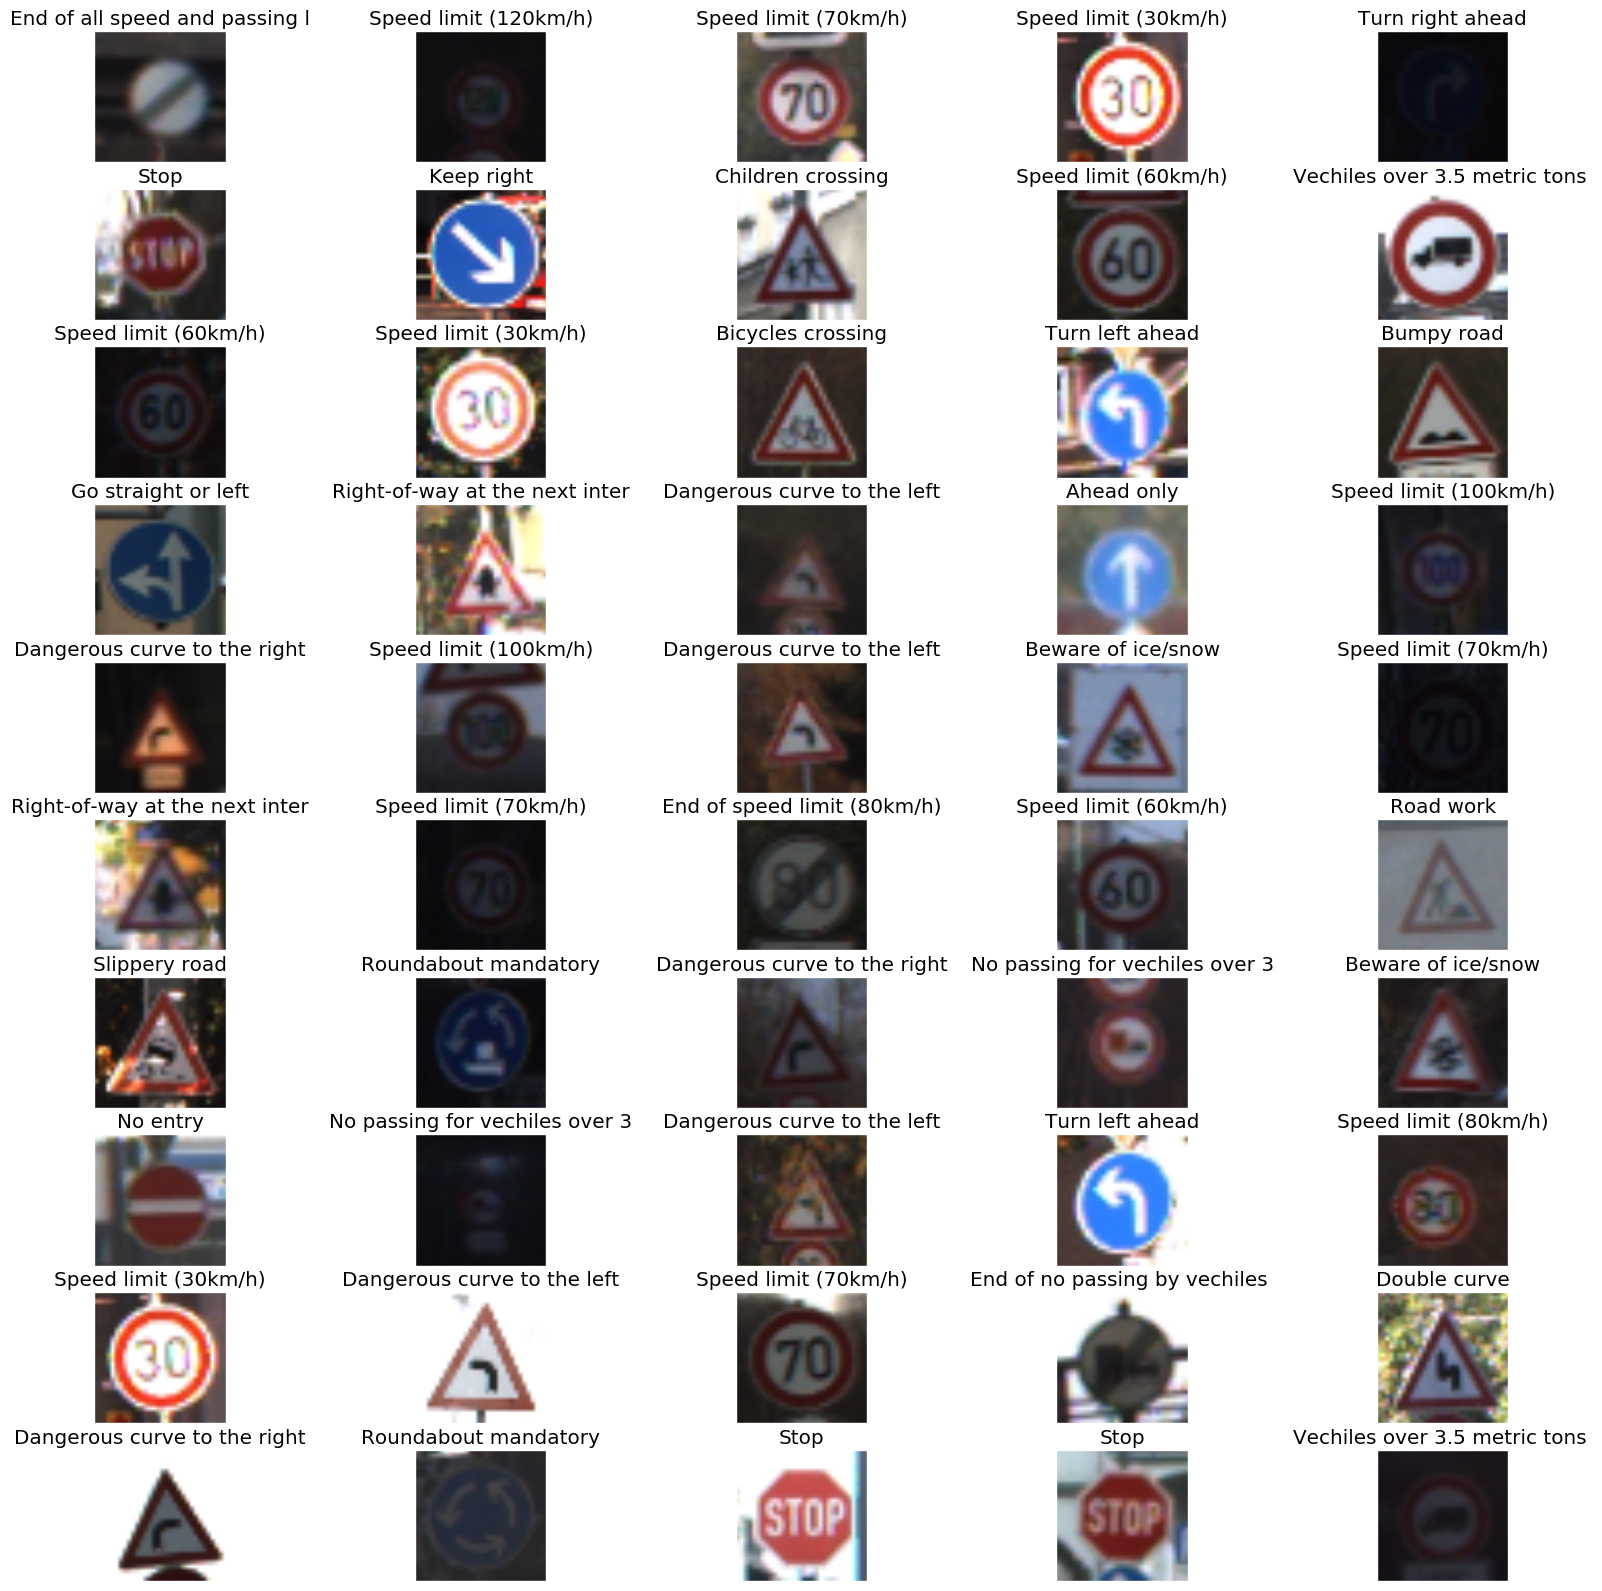

In [218]:
fig = plt.figure(figsize=(20,20))

sidx = np.random.choice(idx, size=50, replace=False)
for i, c in enumerate(sidx):
    ax = fig.add_subplot(10, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[y_train[c],'SignName'][:30])
    ax.imshow(X_train[c])

It's important to note that these images haven't been augmented yet. That means that each training batch represents a lot of new information.

Finally, the test set was left intact for the sake of having a good point of comparison. 

(array([  60.,  720.,  750.,  450.,  660.,  630.,  150.,  450.,  450.,
         480.,  660.,  420.,  690.,  720.,  270.,  210.,  150.,  360.,
         390.,   60.,   90.,   90.,  120.,  150.,   90.,  480.,  180.,
          60.,  150.,   90.,  150.,  270.,   60.,  210.,  120.,  390.,
         120.,   60.,  690.,   90.,   90.,   60.,   90.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

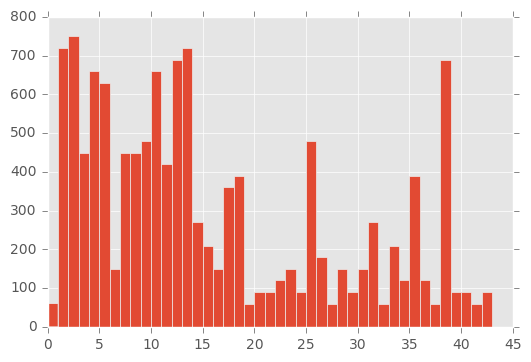

In [219]:
plt.hist(y_test, bins=range(n_classes + 1))

#### Helper Functions

In [220]:
def eval_img(saver, logits, img, label, 
             images_p, labels_p, keep_prob_p):
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('checkpoint_dir')
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        else:
            return
        sign_strings = pd.read_csv('signnames.csv', index_col=0)
        slabel = label if label else [0]
        probs = sess.run(logits, feed_dict={images_p:img, 
                                            labels_p:slabel, 
                                            keep_prob_p:1.0})[0]
        sign_strings['prob'] = pd.Series(probs, index=sign_strings.index)
        if label:
            sign_strings['correct'] = pd.Series(sign_strings.index.values == label, index=sign_strings.index)
        return sign_strings.sort_values(['prob', 'SignName'], ascending=[0, 1])


def eval_once(saver, top_k_op, X_test, y_test, 
              images_p, labels_p, keep_prob_p):
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('checkpoint_dir')
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        else:
            print('No checkpoint file found')
            return

        predictions = sess.run(top_k_op, feed_dict={images_p:X_test, 
                                                    labels_p:y_test, 
                                                    keep_prob_p:1.0})
        print(global_step)
        true_count = np.sum(predictions)
        precision = true_count / len(X_test)
    return precision

def get_precision(k = 1):
    with tf.Graph().as_default() as g:
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        # Augment images batch
        process_op = augment_images(images_p)

        # Calculate the logits and loss
        pool2 = convolutions(process_op)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)

        # Calculate predictions.
        top_k_op = tf.nn.in_top_k(logits, labels_p, k)

        # Restore the moving average version of the learned variables for eval.
        variable_averages = tf.train.ExponentialMovingAverage(
            classifier.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)    
        precision = eval_once(saver, top_k_op, X_test, y_test, 
                              images_p, labels_p, keep_prob_p)
        print('%s: Test Set Top %s Precision %.3f' % (datetime.datetime.now(), k, precision))
        

def get_top_matches(image, label = None):
    with tf.Graph().as_default() as g:
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        process_op = augment_images(images_p)

        pool2 = convolutions(process_op)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)
        
        # Restore the moving average version of the learned variables for eval.
        variable_averages = tf.train.ExponentialMovingAverage(
            classifier.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)  
        predictions = eval_img(saver, logits,
                               image, label,
                               images_p, labels_p, keep_prob_p)
        return predictions

In [222]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=1)

    thresh = 0.7
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Our model evaluation is composed of several metrics. We calculated the accuracy, weighted precision, weighted recall, weighted f1 score and cohen kappa score of the batches, training, validation and test set every so often.

/home/mimoralea/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


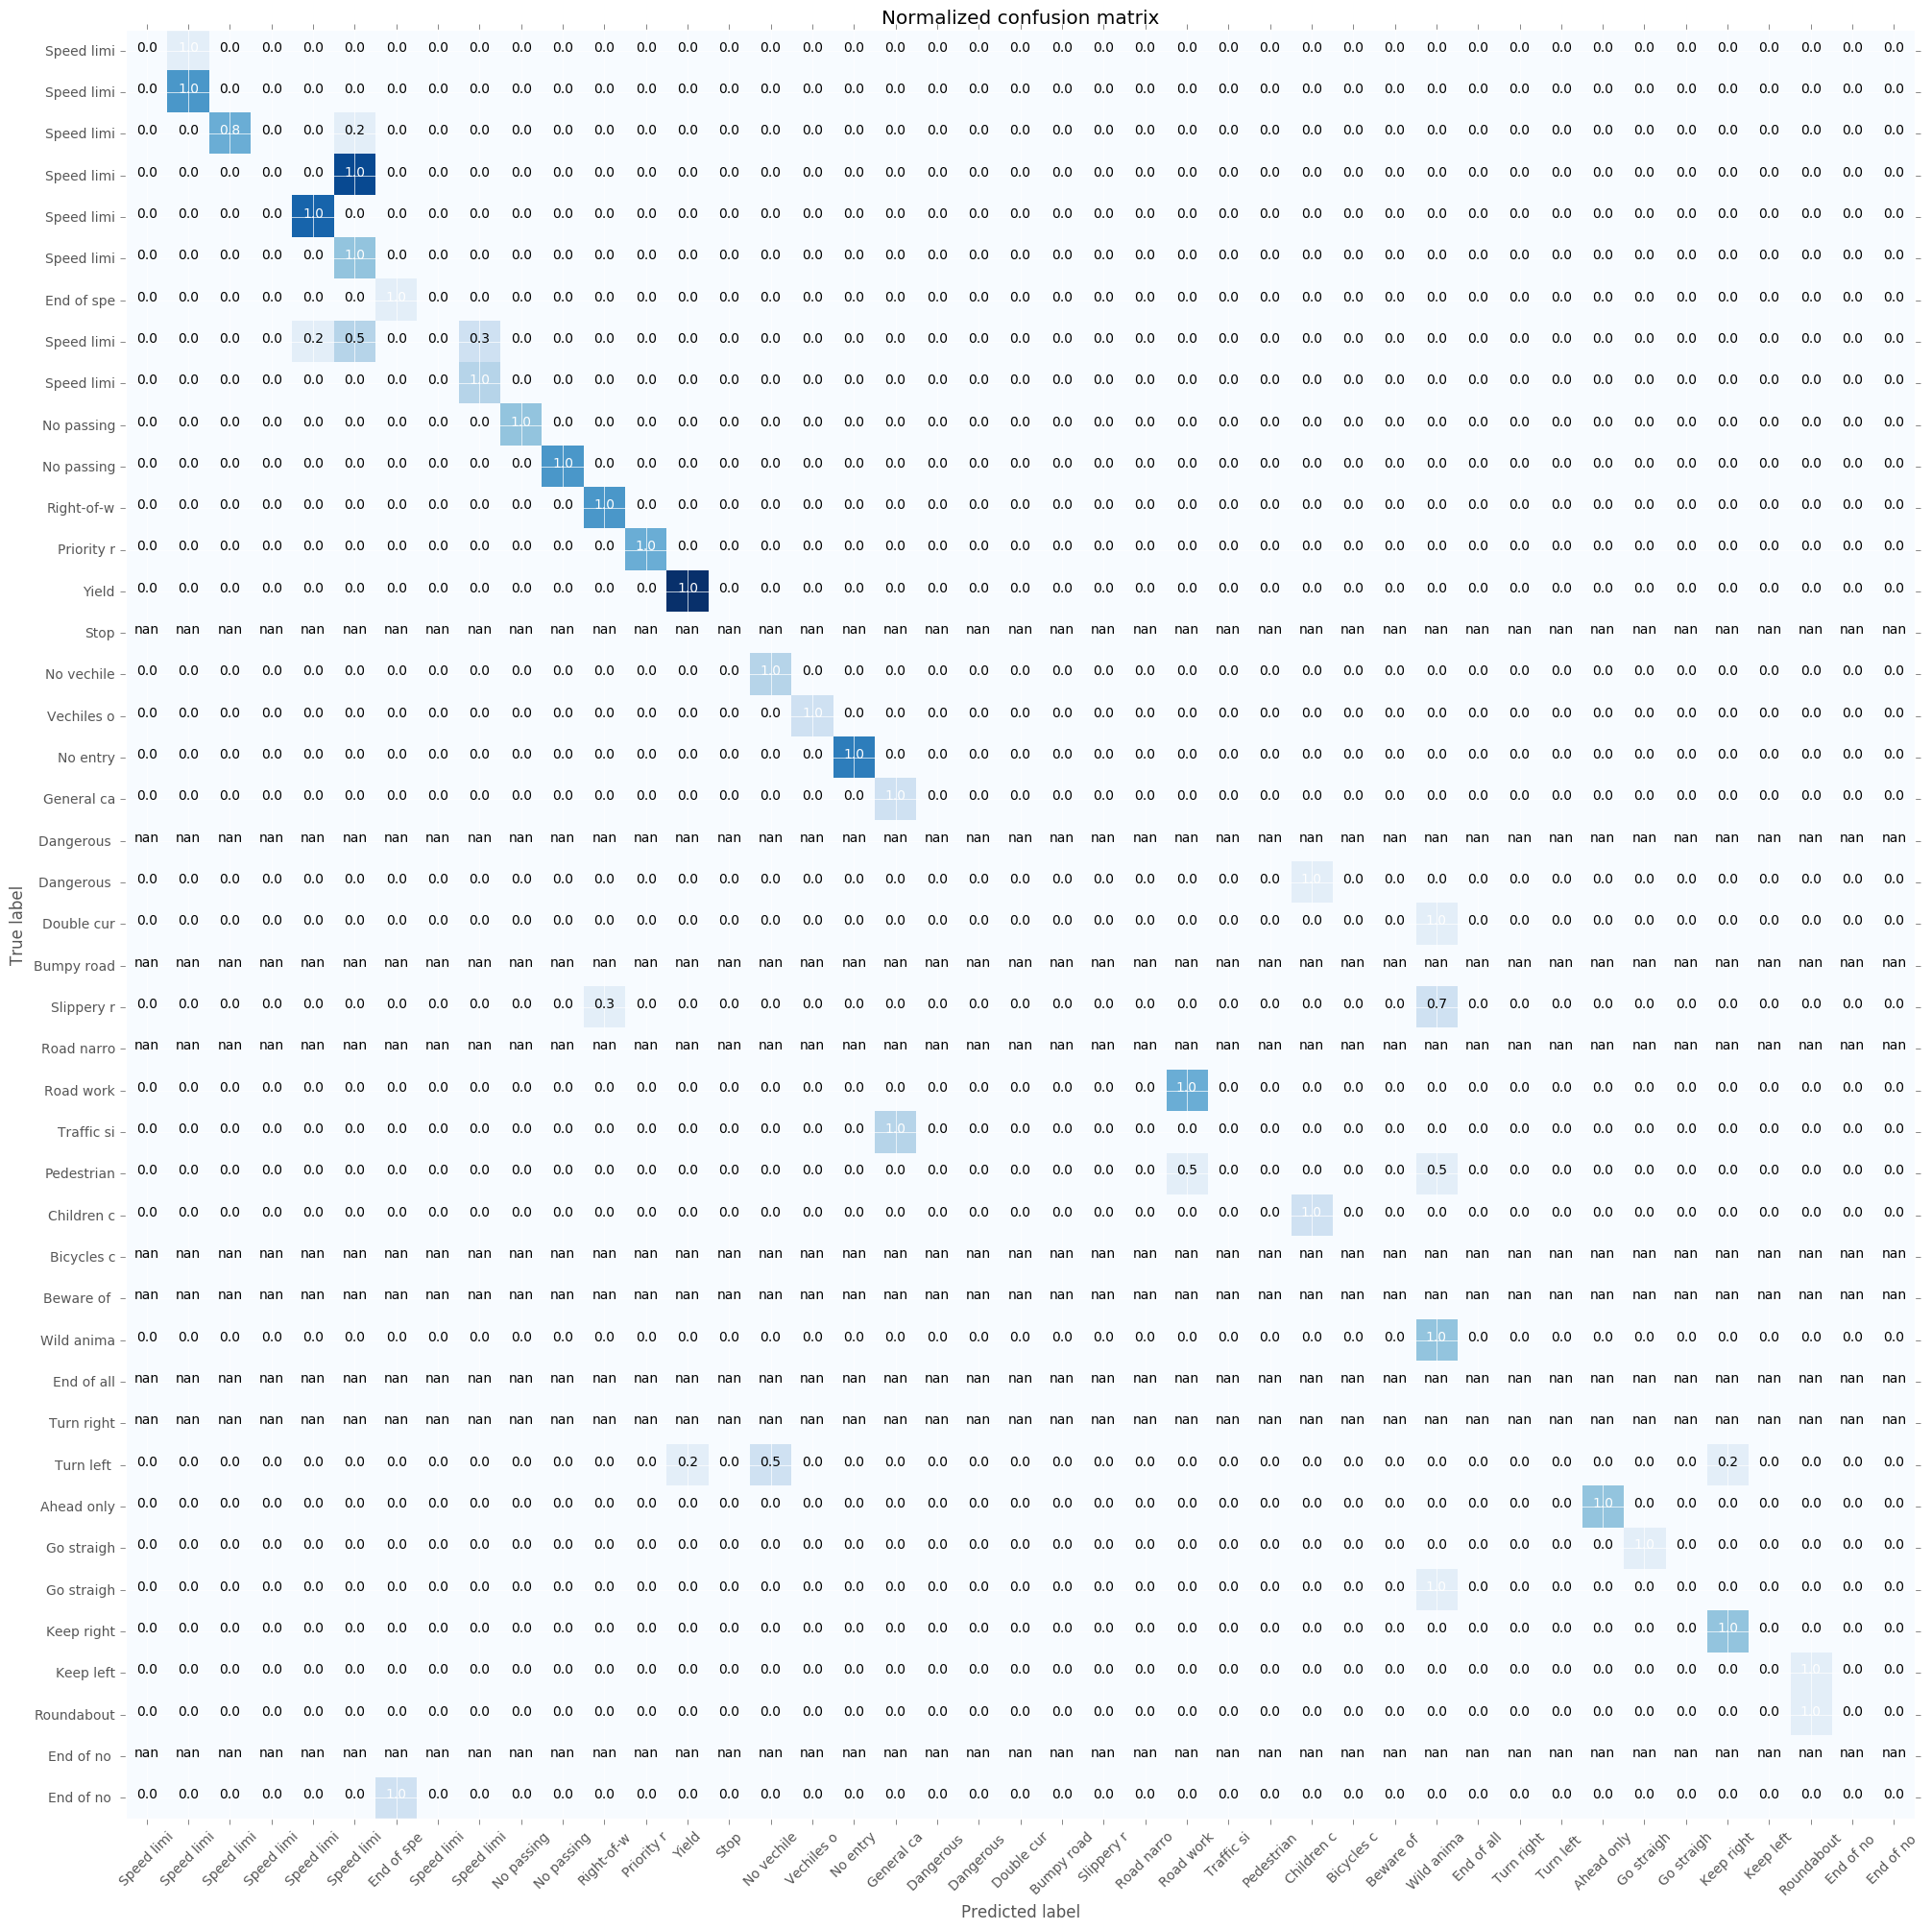

In [181]:
cnf_matrix = np.load('checkpoint_dir/conv2_cmatrix_40000.npz')
# Plot normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=[t[:10] for t in sign_strings['SignName']], 
                      normalize=True, title='Normalized confusion matrix')

#### Raw Accuracy

In the end, our model reached the following precision when compared to the 1 pick.

In [223]:
get_precision(k=1)

KeyboardInterrupt: 

#### Top 5 Accuracy

However, is we take into account the top 5 picks our models does much better.

In [96]:
get_precision(k=5)

2016-11-25 10:22:00.925613: Test Set Top 5 Precision 0.844


#### Single Image Samples

Let's look at specific examples that are interesting.

                                                  SignName          prob  \
ClassId                                                                    
1                                     Speed limit (30km/h)  1.000000e+00   
4                                     Speed limit (70km/h)  1.678992e-09   
2                                     Speed limit (50km/h)  2.023276e-11   
5                                     Speed limit (80km/h)  3.915706e-12   
38                                              Keep right  3.513238e-12   
12                                           Priority road  1.286518e-12   
18                                         General caution  1.200054e-12   
9                                               No passing  3.168488e-13   
8                                    Speed limit (120km/h)  2.852642e-13   
35                                              Ahead only  2.280266e-13   
6                              End of speed limit (80km/h)  2.267161e-13   
15          

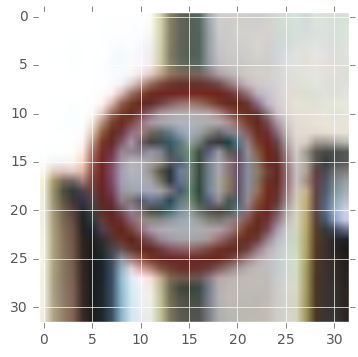

In [91]:
idx = 1032
img = X_train[idx]
label = y_train[idx]
matches = get_top_matches([img], [label])
print(matches)
plt.imshow(img)

#### Localized Images Results

We also tested our model against a few images that do not belong to the original data set, but collected online instead. Let's take a look at the images.

In [224]:
localized_paths = ['imgs/local1.jpg', 'imgs/local2.jpg', 
                   'imgs/local3.jpg', 'imgs/local4.jpg',
                   'imgs/local5.jpg', 'imgs/local6.jpg',
                   'imgs/local7.jpg', 'imgs/local8.jpg',
                   'imgs/local9.jpeg', 'imgs/local10.jpg']
localized_imgs = np.array([misc.imresize(misc.imread(p), (32,32)) for p in localized_paths])

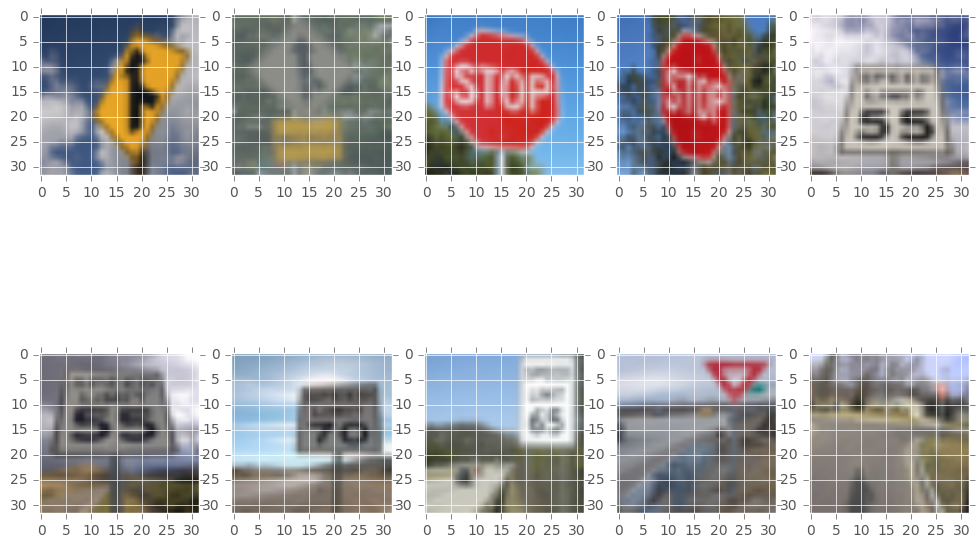

In [226]:
fig = plt.figure(figsize=(12,8))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    #ax.grid(False)
    #ax.get_xaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([])
    ax.imshow(localized_imgs[i])

We performed the data augmentation on these as well (as part of the TensorFlow graph).

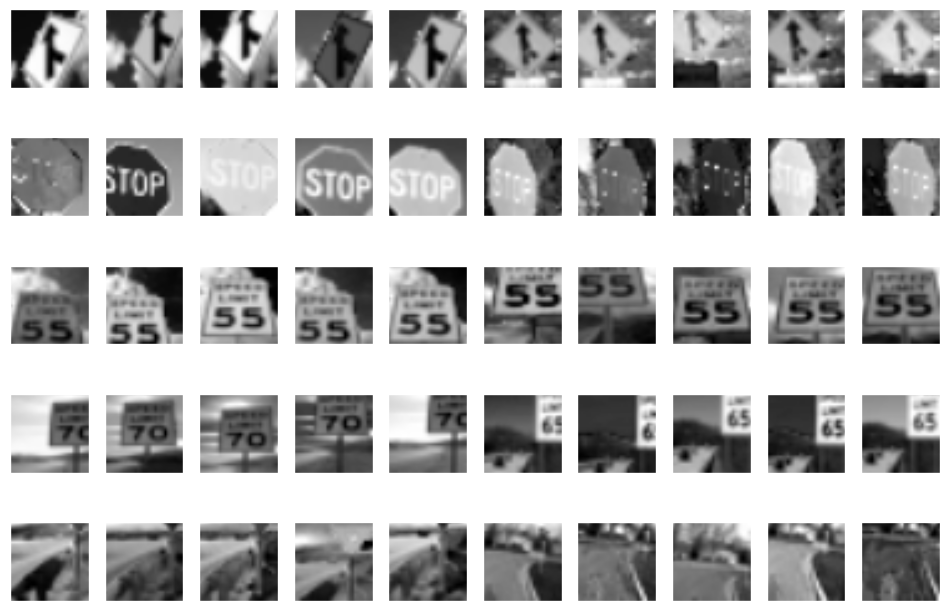

In [227]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        idx = -1
        imgs = []
        for i in range(50):
            if i % 5 == 0 :
                idx += 1
                img = localized_imgs[idx]
            imgs.append(img)
        img_placeholder = tf.placeholder(tf.float32, shape=[50, 32, 32, 3])
        images = augment_images(img_placeholder)
        images = sess.run(images, feed_dict={img_placeholder:imgs})

        fig = plt.figure(figsize=(12,8))
        for i in range(50):
            ax = fig.add_subplot(5, 10, i + 1)
            ax.grid(False)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.imshow(np.squeeze(images[i]), cmap='gray')

Let's see how well our model does when tested on these images.

                                                  SignName          prob
ClassId                                                                 
14                                                    Stop  9.906383e-01
4                                     Speed limit (70km/h)  3.031577e-03
38                                              Keep right  2.173193e-03
13                                                   Yield  1.066023e-03
2                                     Speed limit (50km/h)  1.063674e-03
8                                    Speed limit (120km/h)  3.505361e-04
1                                     Speed limit (30km/h)  2.568956e-04
34                                         Turn left ahead  1.803361e-04
7                                    Speed limit (100km/h)  1.626586e-04
5                                     Speed limit (80km/h)  9.337833e-05
35                                              Ahead only  8.867481e-05
25                                               Ro

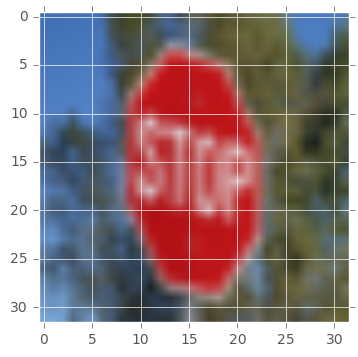

In [92]:
idx = 3
img = localized_imgs[idx]
matches = get_top_matches([img])
print(matches)
plt.imshow(img)

#### Video Stream Results

Finally, we test our model on a video feed. This is a much more challenging task because the model was trained on cropped images, therefore it lacks a detection mechanism.

Traditionally, this problem would be separated into Traffic Sign Detection (TSD) and Traffic Sign Classification (TSC). This project concentrates on TSC because the job of detecting the sign on an image had already been pre-processed on the data. The images came in already cropped centered on the traffic sign. Regardless, this is how the model did on a couple of videos taken by myself for the purpose of this project.

### Q&As

#### Question 1: 
_Describe the techniques used to preprocess the data._

#### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

#### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

#### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

#### Question 5


_What approach did you take in coming up with a solution to this problem?_

#### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._

#### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_

#### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

#### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._